# Importing libraries and classes

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor as SKLearnRandomForestRegressor
from sklearn.tree import DecisionTreeRegressor as SKLearnDecisionTreeRegressor

from DecisionTreeRegressor import DecisionTreeRegressor
from RandomForestRegressor import RandomForestRegressor
from LinearRegression import LogisticRegression

# Reading and splitting the data

In [46]:
df = pd.read_csv('./NSO_Population_Sex_dataset/NSO_POPULATION_DATA_CLEANED.csv')

feature_cols = ['District', 'Sex', 'Year', 'Population_Growth_Rate','Average_Population']
X = pd.get_dummies(df[feature_cols], columns=['District', 'Sex'])
y = df["Population"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# SKLearn Decision Trees

In [47]:
SKLearn_Decision_Tree_Regressor = SKLearnDecisionTreeRegressor(max_depth=100, min_samples_split=2, min_samples_leaf=5)

SKLearn_Decision_Tree_Regressor.fit(X_train, y_train)

SKLearn_Decision_Tree_Regressor_Prediction = SKLearn_Decision_Tree_Regressor.predict(X_test)

SKLearn_Decision_Tree_Regressor_Prediction_MAE = mean_absolute_error(y_test, SKLearn_Decision_Tree_Regressor_Prediction)
SKLearn_Decision_Tree_Regressor_Prediction_MSE = mean_squared_error(y_test, SKLearn_Decision_Tree_Regressor_Prediction)
SKLearn_Decision_Tree_Regressor_Prediction_R2 = r2_score(y_test, SKLearn_Decision_Tree_Regressor_Prediction)

print(f"SKLearn Decision Tree Regressor Mean Absolute Error: {SKLearn_Decision_Tree_Regressor_Prediction_MAE}")
print(f"SKLearn Decision Tree Regressor Mean Squared Error: {SKLearn_Decision_Tree_Regressor_Prediction_MSE}")
print(f"SKLearn Decision Tree Regressor R\u00b2: {SKLearn_Decision_Tree_Regressor_Prediction_R2}")

SKLearn_Decision_Tree_Regressor_Results_DF = pd.DataFrame({'Actual': y_test, 'Predicted': SKLearn_Decision_Tree_Regressor_Prediction})
print(f"\nSKLearn Decision Tree Predictions:\n{SKLearn_Decision_Tree_Regressor_Results_DF}")

SKLearn Decision Tree Regressor Mean Absolute Error: 0.014600764500040652
SKLearn Decision Tree Regressor Mean Squared Error: 0.000546366741966023
SKLearn Decision Tree Regressor R²: 0.9867108691772756

SKLearn Decision Tree Predictions:
       Actual  Predicted
164  0.006728   0.006348
158  0.400089   0.343890
91   0.244705   0.253271
27   0.336552   0.337742
162  0.005385   0.006348
99   0.178442   0.194805
148  0.208270   0.222876
41   0.689139   0.671232
94   0.267079   0.343890
119  0.190878   0.188824
14   0.379004   0.357019
140  0.318650   0.290216
122  0.198238   0.205902
174  0.022549   0.023330
151  0.227354   0.237966
187  0.010368   0.009068
20   0.333208   0.330503
62   0.890520   0.862893
126  0.211856   0.205902
157  0.361599   0.290216
156  0.325687   0.290216
108  0.200669   0.205902
36   0.591961   0.587397
173  0.018144   0.023330
85   0.215912   0.216932
79   0.325540   0.343890
137  0.254603   0.290216
166  0.007266   0.006348
116  0.186017   0.188824
172  0.01477

# Custom Decision Trees

In [48]:
Custom_Decision_Tree_Regressor = DecisionTreeRegressor(max_depth=100, min_samples_split=2)

Custom_Decision_Tree_Regressor.fit(X_train.values, y_train.values)

Custom_Decision_Tree_Regressor_Prediction = Custom_Decision_Tree_Regressor.predict(X_test.values)

Custom_Decision_Tree_Regressor_Prediction_MAE = mean_absolute_error(y_test, Custom_Decision_Tree_Regressor_Prediction)
Custom_Decision_Tree_Regressor_Prediction_MSE = mean_squared_error(y_test, Custom_Decision_Tree_Regressor_Prediction)
Custom_Decision_Tree_Regressor_Prediction_R2 = r2_score(y_test, Custom_Decision_Tree_Regressor_Prediction)

print(f"Custom Decision Tree Regressor Mean Absolute Error: {Custom_Decision_Tree_Regressor_Prediction_MAE}")
print(f"Custom Decision Tree Regressor Mean Squared Error: {Custom_Decision_Tree_Regressor_Prediction_MSE}")
print(f"Custom Decision Tree Regressor R\u00b2: {Custom_Decision_Tree_Regressor_Prediction_R2}")

Custom_Decision_Tree_Regressor_Results_DF = pd.DataFrame({'Actual': y_test, 'Predicted': Custom_Decision_Tree_Regressor_Prediction})
print(f"\nCustom Decision Tree Predictions:\n{Custom_Decision_Tree_Regressor_Results_DF}")

Custom Decision Tree Regressor Mean Absolute Error: 0.015029378655975143
Custom Decision Tree Regressor Mean Squared Error: 0.000682269995670212
Custom Decision Tree Regressor R²: 0.9834053310121776

Custom Decision Tree Predictions:
       Actual  Predicted
164  0.006728   0.006809
158  0.400089   0.365064
91   0.244705   0.250547
27   0.336552   0.336176
162  0.005385   0.005896
99   0.178442   0.213333
148  0.208270   0.209815
41   0.689139   0.731819
94   0.267079   0.324062
119  0.190878   0.225957
14   0.379004   0.378399
140  0.318650   0.285545
122  0.198238   0.192718
174  0.022549   0.024187
151  0.227354   0.240905
187  0.010368   0.011577
20   0.333208   0.333571
62   0.890520   0.984932
126  0.211856   0.220062
157  0.361599   0.342824
156  0.325687   0.285545
108  0.200669   0.196586
36   0.591961   0.589302
173  0.018144   0.019675
85   0.215912   0.225675
79   0.325540   0.268852
137  0.254603   0.254724
166  0.007266   0.007185
116  0.186017   0.186688
172  0.014773   

# Random Forest Regressor using SKLearn
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [49]:
SKLearn_Random_Forest_Regressor = SKLearnRandomForestRegressor() # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

SKLearn_Random_Forest_Regressor.fit(X_train, y_train)

SKLearn_Random_Forest_Regressor_Prediction = SKLearn_Random_Forest_Regressor.predict(X_test)

SKLearn_Random_Forest_Regressor_Prediction_MAE = mean_absolute_error(y_test, SKLearn_Random_Forest_Regressor_Prediction)
SKLearn_Random_Forest_Regressor_Prediction_MSE = mean_squared_error(y_test, SKLearn_Random_Forest_Regressor_Prediction)
SKLearn_Random_Forest_Regressor_Prediction_R2 = r2_score(y_test, SKLearn_Random_Forest_Regressor_Prediction)

print(f"SKLearn Random Forest Regressor Mean Absolute Error: {SKLearn_Random_Forest_Regressor_Prediction_MAE}")
print(f"SKLearn Random Forest Regressor Mean Squared Error: {SKLearn_Random_Forest_Regressor_Prediction_MSE}")
print(f"SKLearn Random Forest Regressor R\u00b2: {SKLearn_Decision_Tree_Regressor_Prediction_R2}")

SKLearn_Random_Forest_Regressor_Results_DF = pd.DataFrame({'Actual': y_test, 'Predicted': SKLearn_Random_Forest_Regressor_Prediction})
print(f"\nSKLearn Random Forest Predictions:\n{SKLearn_Random_Forest_Regressor_Results_DF}")


SKLearn Random Forest Regressor Mean Absolute Error: 0.008287188027186114
SKLearn Random Forest Regressor Mean Squared Error: 0.00020728938631376674
SKLearn Random Forest Regressor R²: 0.9867108691772756

SKLearn Random Forest Predictions:
       Actual  Predicted
164  0.006728   0.006895
158  0.400089   0.348287
91   0.244705   0.232782
27   0.336552   0.335435
162  0.005385   0.005505
99   0.178442   0.185118
148  0.208270   0.212901
41   0.689139   0.665841
94   0.267079   0.276462
119  0.190878   0.187907
14   0.379004   0.356905
140  0.318650   0.294866
122  0.198238   0.196563
174  0.022549   0.023813
151  0.227354   0.230455
187  0.010368   0.010473
20   0.333208   0.331983
62   0.890520   0.899268
126  0.211856   0.216579
157  0.361599   0.332977
156  0.325687   0.297566
108  0.200669   0.206169
36   0.591961   0.592517
173  0.018144   0.017986
85   0.215912   0.218475
79   0.325540   0.291247
137  0.254603   0.256430
166  0.007266   0.006639
116  0.186017   0.185501
172  0.014

# Custom Random Forest Regressor using SKLearn Decision Trees

In [50]:
SKLearn_Decision_Trees_Random_Forest_Regressor = RandomForestRegressor(n_estimators=100, max_depth=None, custom=False)
SKLearn_Decision_Trees_Random_Forest_Regressor.fit(X_train, y_train)

SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction = SKLearn_Decision_Trees_Random_Forest_Regressor.predict(X_test)

SKLearn_Decision_Trees_Random_Forest_Regressor_MAE = mean_absolute_error(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)
SKLearn_Decision_Trees_Random_Forest_Regressor_MSE = mean_squared_error(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)
SKLearn_Decision_Trees_Random_Forest_Regressor_R2 = r2_score(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)

print(f"Custom Random Forest Regressor using SKLearn Decision Trees Mean Absolute Error: {SKLearn_Decision_Trees_Random_Forest_Regressor_MAE}")
print(f"Custom Random Forest Regressor using SKLearn Decision Trees Mean Squared Error: {SKLearn_Decision_Trees_Random_Forest_Regressor_MSE}")
print(f"Custom Random Forest Regressor using SKLearn Decision Trees R\u00b2: {SKLearn_Decision_Trees_Random_Forest_Regressor_R2}")

SKLearn_Decision_Trees_Random_Forest_Regressor_Results_DF = pd.DataFrame({'Actual': y_test, 'Predicted': SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction})
print(f"\nCustom Random Forest Regressor using SKLearn Decision Trees Predictions:\n{SKLearn_Decision_Trees_Random_Forest_Regressor_Results_DF}")

Custom Random Forest Regressor using SKLearn Decision Trees Mean Absolute Error: 0.009311682350320042
Custom Random Forest Regressor using SKLearn Decision Trees Mean Squared Error: 0.00027251900251000613
Custom Random Forest Regressor using SKLearn Decision Trees R²: 0.9933715938437208

Custom Random Forest Regressor using SKLearn Decision Trees Predictions:
       Actual  Predicted
164  0.006728   0.006468
158  0.400089   0.342696
91   0.244705   0.236278
27   0.336552   0.336095
162  0.005385   0.005732
99   0.178442   0.189577
148  0.208270   0.212847
41   0.689139   0.655628
94   0.267079   0.271550
119  0.190878   0.187839
14   0.379004   0.358253
140  0.318650   0.297852
122  0.198238   0.197664
174  0.022549   0.024742
151  0.227354   0.230226
187  0.010368   0.010467
20   0.333208   0.332219
62   0.890520   0.880650
126  0.211856   0.219738
157  0.361599   0.326694
156  0.325687   0.295470
108  0.200669   0.207118
36   0.591961   0.594022
173  0.018144   0.019179
85   0.215912

# Custom Random Forest Regressor

In [51]:
Custom_Random_Forest_Regressor = RandomForestRegressor(n_estimators=100, max_depth=100)
Custom_Random_Forest_Regressor.fit(X_train, y_train)

Custom_Random_Forest_Regressor_Prediction = Custom_Random_Forest_Regressor.predict(X_test)

Custom_Random_Forest_Regressor_MAE = mean_absolute_error(y_test, Custom_Random_Forest_Regressor_Prediction)
Custom_Random_Forest_Regressor_MSE = mean_squared_error(y_test, Custom_Random_Forest_Regressor_Prediction)
Custom_Random_Forest_Regressor_R2 = r2_score(y_test, Custom_Random_Forest_Regressor_Prediction)

print(f"Custom Random Forest Regressor Mean Absolute Error: {Custom_Random_Forest_Regressor_MAE}")
print(f"Custom Random Forest Regressor Mean Squared Error: {Custom_Random_Forest_Regressor_MSE}")
print(f"Custom Random Forest Regressor R\u00b2: {Custom_Random_Forest_Regressor_R2}")

Custom_Random_Forest_Regressor_Results_DF = pd.DataFrame({'Actual': y_test, 'Predicted': Custom_Random_Forest_Regressor_Prediction})
print(f"\nCustom Random Forest Regressor Predictions:\n{Custom_Random_Forest_Regressor_Results_DF}")

Custom Random Forest Regressor Mean Absolute Error: 0.011920891989921415
Custom Random Forest Regressor Mean Squared Error: 0.0004378316906079441
Custom Random Forest Regressor R²: 0.9893507379422714

Custom Random Forest Regressor Predictions:
       Actual  Predicted
164  0.006728   0.006278
158  0.400089   0.349445
91   0.244705   0.239597
27   0.336552   0.339192
162  0.005385   0.005677
99   0.178442   0.194939
148  0.208270   0.214510
41   0.689139   0.740311
94   0.267079   0.284160
119  0.190878   0.201767
14   0.379004   0.363533
140  0.318650   0.319729
122  0.198238   0.195683
174  0.022549   0.026484
151  0.227354   0.233929
187  0.010368   0.012050
20   0.333208   0.331780
62   0.890520   0.959000
126  0.211856   0.222275
157  0.361599   0.331961
156  0.325687   0.319521
108  0.200669   0.212664
36   0.591961   0.595806
173  0.018144   0.022547
85   0.215912   0.217919
79   0.325540   0.278967
137  0.254603   0.259091
166  0.007266   0.006715
116  0.186017   0.187432
172  

# Custom Linear Regression

In [52]:
# Normalisation of data 

X_train_normalized = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test_normalized = (X_test - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

In [53]:
Custom_Linear_Regression = LogisticRegression(learning_rate=0.01, num_iterations=1000)
Custom_Linear_Regression.fit(X_train_normalized, y_train)

Custom_Linear_Regression_Prediction = Custom_Linear_Regression.predict(X_test_normalized)

Custom_Linear_Regression_MAE = mean_absolute_error(y_test, Custom_Linear_Regression_Prediction)
Custom_Linear_Regression_MSE = mean_squared_error(y_test, Custom_Linear_Regression_Prediction)
Custom_Linear_Regression_R2 = r2_score(y_test, Custom_Linear_Regression_Prediction)

print(f"Custom Linear Regression Mean Absolute Error: {Custom_Linear_Regression_MAE}")
print(f"Custom Linear Regression Mean Squared Error: {Custom_Linear_Regression_MSE}")
print(f"Custom Linear Regression R\u00b2: {Custom_Linear_Regression_R2}")


Custom_Linear_Regression_Results_DF = pd.DataFrame({'Actual': y_test, 'Predicted': Custom_Linear_Regression_Prediction})
print(f"\nCustom Linear Regression Predictions:\n{Custom_Linear_Regression_Results_DF}")

Custom Linear Regression Mean Absolute Error: 0.04744189455052452
Custom Linear Regression Mean Squared Error: 0.0029870706549821272
Custom Linear Regression R²: 0.9273462865474941

Custom Linear Regression Predictions:
       Actual  Predicted
164  0.006728   0.070790
158  0.400089   0.328932
91   0.244705   0.287958
27   0.336552   0.389155
162  0.005385   0.066506
99   0.178442   0.193413
148  0.208270   0.251164
41   0.689139   0.744664
94   0.267079   0.311885
119  0.190878   0.214472
14   0.379004   0.421807
140  0.318650   0.307038
122  0.198238   0.234632
174  0.022549   0.099749
151  0.227354   0.274056
187  0.010368   0.091646
20   0.333208   0.327148
62   0.890520   0.775687
126  0.211856   0.263576
157  0.361599   0.320317
156  0.325687   0.312116
108  0.200669   0.253621
36   0.591961   0.707945
173  0.018144   0.096486
85   0.215912   0.242533
79   0.325540   0.326674
137  0.254603   0.283700
166  0.007266   0.076755
116  0.186017   0.195575
172  0.014773   0.092625
182  

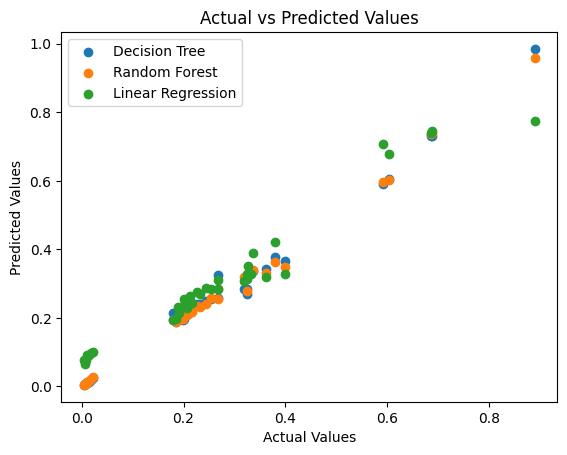

In [54]:
plt.scatter(y_test, Custom_Decision_Tree_Regressor_Prediction)
plt.scatter(y_test, Custom_Random_Forest_Regressor_Prediction)
plt.scatter(y_test, Custom_Linear_Regression_Prediction)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend(['Decision Tree', 'Random Forest', 'Linear Regression'])
plt.show()